<a href="https://colab.research.google.com/github/julianovale/MCDA/blob/main/0011_Trabalho_INSID_PrometheeII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ver isso: https://towardsdatascience.com/how-to-compute-satellite-image-statistics-and-use-it-in-pandas-81864a489144

In [2]:
! pip install geopandas

     |████████████████████████████████| 1.0MB 5.1MB/s 
     |████████████████████████████████| 6.6MB 27.3MB/s 
     |████████████████████████████████| 15.4MB 189kB/s 


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [4]:
! rm *.*

rm: cannot remove '*.*': No such file or directory


In [5]:
! wget https://github.com/julianovale/MCDA/raw/main/INSID/DadosPromethee.zip
! unzip DadosPromethee.zip
! wget https://github.com/julianovale/MCDA/raw/main/INSID/Logradouros.zip
! unzip Logradouros.zip
! ls

--2021-07-06 16:26:56--  https://github.com/julianovale/MCDA/raw/main/INSID/DadosPromethee.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/julianovale/MCDA/main/INSID/DadosPromethee.zip [following]
--2021-07-06 16:26:56--  https://raw.githubusercontent.com/julianovale/MCDA/main/INSID/DadosPromethee.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29200 (29K) [application/zip]
Saving to: ‘DadosPromethee.zip’

DadosPromethee.zip  100%[===================>]  28.52K  --.-KB/s    in 0.001s  

2021-07-06 16:26:56 (18.7 MB/s) - ‘DadosPromethee.zip’ saved [29200/29200]

Archive:  DadosPromethee.z

In [6]:
setores = gpd.read_file('DadosPromethee.shp')
setores.head()

,ID,CD_GEOCODI,AREA_KM2,Rank,NDVI,Dens_Dem_H,Renda,Infra,%Alfabetiz,geometry
0,88939.0,352670405000001,0.16547,9,-0.81,0.64,0.76,0.57,0.98,"POLYGON ((-47.38783 -22.18287, -47.38729 -22.1..."
1,88940.0,352670405000002,0.23188,22,-0.78,0.74,0.97,-0.18,0.95,"POLYGON ((-47.38756 -22.18164, -47.38668 -22.1..."
2,88941.0,352670405000003,0.18694,27,-0.26,0.34,0.81,0.57,0.12,"POLYGON ((-47.38244 -22.18438, -47.38201 -22.1..."
3,88942.0,352670405000004,0.11315,25,-0.38,0.12,0.59,0.57,0.57,"POLYGON ((-47.38602 -22.18627, -47.38573 -22.1..."
4,88943.0,352670405000005,0.07081,40,-0.64,-0.29,0.90,-0.18,0.78,"POLYGON ((-47.38846 -22.19355, -47.38716 -22.1..."


In [7]:
Teste = setores[['NDVI','Dens_Dem_H','Renda','Infra','%Alfabetiz']].to_numpy()

In [8]:
# Filename: PROMETHEE_Preference_Functions.py
# Description: This module calculates the
# unicriterion preference degrees of the actions
# for a specific criterion
# Authors: Papathanasiou, J. & Ploskas, N.

from numpy import *

# Calculate the unicriterion preference degrees
def uni_cal(x, p, c, f):
    """ x is the action performances array, p is the
    array with the preference parameters of all 
	criteria, c is the criteria min (0) or max (1) 
	optimization array, and f is the preference 
	function array for a specific criterion ('u' 
	for usual, 'us' for u-shape, 'vs' for v-shape, 
	'le' for level, 'li' for linear, and 'g' for 
	Gaussian)
    """
    uni = zeros((x.shape[0], x.shape[0]))
    for i in range(size(uni, 0)):
        for j in range(size(uni, 1)):
            if i == j:
                uni[i, j] = 0
            elif f == 'u':  # Usual preference function
                if x[j] - x[i] > 0:
                    uni[i, j] = 1
                else:
                    uni[i, j] = 0
            elif f == 'us': # U-shape preference function
                if x[j] - x[i] > x[0]:
                    uni[i, j] = 1
                elif x[j] - x[i] <= p[0]:
                    uni[i, j] = 0
            elif f == 'vs': # V-shape preference function
                if x[j] - x[i] > p[1]:
                    uni[i, j] = 1
                elif x[j] - x[i] <= 0:
                    uni[i, j] = 0
                else:
                    uni[i, j] = (x[j] - x[i]) / p[1]
            elif f == 'le': # Level preference function
                if x[j] - x[i] > p[1]:
                    uni[i, j] = 1
                elif x[j] - x[i] <= p[0]:
                    uni[i, j] = 0
                else:
                    uni[i, j] = 0.5
            elif f == 'li': # Linear preference function
                if x[j] - x[i] > p[1]:
                    uni[i, j] = 1
                elif x[j] - x[i] <= p[0]:
                    uni[i, j] = 0
                else:
                    uni[i, j] = ((x[j] - x[i]) -
                        p[0]) / (p[1] - p[0])
            elif f == 'g':  # Gaussian preference function
                if x[j] - x[i] > 0:
                    uni[i, j] = 1 - math.exp(-(math.pow(x[j]
                        - x[i], 2) / (2 * p[1] ** 2)))
                else:
                    uni[i, j] = 0
    if c == 0:
        uni = uni
    elif c == 1:
        uni = uni.T
    # positive, negative and net flows
    pos_flows = sum(uni, 1) / (uni.shape[0] - 1)
    neg_flows = sum(uni, 0) / (uni.shape[0] - 1)
    net_flows = pos_flows - neg_flows
    return net_flows

In [9]:
# Filename: PROMETHEE_Final_Rank_Figure.py
# Description: Optional module to plot the
# results of PROMETHEE method
# Authors: Papathanasiou, J. & Ploskas, N.

import matplotlib.pyplot as plt
from graphviz import Digraph
from numpy import *

# Plot final rank figure
def graph(flows, b):
    """ flows is the matrix with the net flows, and b
    is a string describing the net flow
    """
    s = Digraph('Actions', node_attr = {'shape':
        'plaintext'})
    s.body.extend(['rankdir = LR'])
    x = sort(flows)
    y = argsort(flows)
    l = []
    for i in y:
        s.node('action' + str(i), '''<
        <TABLE BORDER="0" CELLBORDER="1"
            CELLSPACING="0" CELLPADDING="4">
          <TR>
            <TD COLSPAN="2" bgcolor="grey" >Action
                ''' + str(y[i] + 1) + '''</TD>
          </TR>
          <TR>
            <TD>'''+ b +'''</TD>
            <TD>''' + str(x[i]) + '''</TD>
          </TR>
        </TABLE>>''')
    k = []
    for q in range(len(flows) - 1):
        k.append(['action' + str(q + 1), 'action'
            + str(q)])
    print(k)
    s.edges(k)
    s.view()

# Plot final rank
def plot(a, b):
    """ a is the matrix with the net flows, and b
    is a string describing the method
    """
    flows = a
    yaxes_list = [0.2] * size(flows, 0)
    plt.plot(yaxes_list, flows, 'ro')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    plt.axis([0, 0.7, min(flows) - 0.05,
        max(flows) + 0.05])
    plt.title(b + " results")
    plt.ylabel("Flows")
    plt.legend()
    plt.grid(True)
    z1 = []
    for i in range(size(flows, 0)):
        z1.append('   (Action ' + str(i + 1) + ')')
    z = [str(a) + b for a, b in zip(flows, z1)]
    for X, Y, Z in zip(yaxes_list, flows, z):
        plt.annotate('{}'.format(Z), xy = (X, Y),
            xytext=(10, -4), ha = 'left',
            textcoords = 'offset points')
    plt.show()

In [10]:
# Filename: PROMETHEE_II.py
# Description: PROMETHEE II method
# Authors: Papathanasiou, J. & Ploskas, N.

# PROMETHEE method: it calls the other functions
def promethee(x, p, c, d, w):
    """ x is the action performances array, b is the
    array with the preference parameters of all 
	criteria, c is the criteria min (0) or max (1) 
	optimization array, d is the preference 
	function array ('u' for usual, 'us' for 
	u-shape, 'vs' for v-shape, 'le' for level, 
	'li' for linear, and 'g' for Gaussian), and w
    is the weights array
    """
    weighted_uni_net_flows = []
    total_net_flows = []
    for i in range(x.shape[1]):
        weighted_uni_net_flows.append(w[i] *
            uni_cal(x[:, i:i + 1], p[:,
            i:i + 1], c[i], d[i]))
	
    # print the weighted unicriterion preference
    # net flows
    for i in range(size(weighted_uni_net_flows, 1)):
        k = 0
        for j in range(size(weighted_uni_net_flows, 0)):
            k = k + round(weighted_uni_net_flows[j][i], 5)
        total_net_flows.append(k)
    return around(total_net_flows, decimals = 4)

# main function
def main(a, b):
    """ a and b are flags; if they are set to 'y' they do
    print the results, anything else does not print
    the results
	"""

    # action performances array
    xi = Teste
    x = array(xi)

    # preference parameters of all criteria array
    p = array([[1, 1, 1, 1, 1], [2, 2, 2, 2, 2]])

    # criteria min (0) or max (1) optimization array
    c = ([1, 0, 1, 1, 1])

    # preference function array
    d = (['u', 'u', 'u', 'u', 'u'])

    # weights of criteria
    w = array([0.159, 0.108, 0.194, 0.247, 0.292])

    # final results
    final_net_flows = promethee(x, p, c, d, w)
    print("Global preference flows = ", final_net_flows)
    if a == 'y':
        graph(final_net_flows, "Phi")
    if b == 'y':
        plot(final_net_flows, "PROMETHEE II")
    return final_net_flows

# if __name__ == '__main__':
#    main('n','y')

Global preference flows =  [ 0.3769  0.2161  0.2546  0.347   0.286   0.5951  0.4176  0.3414  0.3293
  0.5735  0.3131  0.5751  0.1068  0.1771  0.3071  0.4265  0.1646  0.2517
  0.4784  0.3311  0.1323  0.0804  0.109   0.0237  0.0526  0.5277  0.3081
  0.25   -0.1146  0.5396  0.3523  0.4142  0.3136  0.3695 -0.0292  0.2154
  0.2896 -0.0588 -0.1867  0.429  -0.007   0.2919  0.3229  0.1944  0.3022
 -0.4589  0.2769  0.0861 -0.3091 -0.174  -0.2472  0.3024 -0.3468 -0.0448
 -0.1296 -0.5313  0.1949  0.0308  0.0171  0.119  -0.1528 -0.1429  0.3573
 -0.1926 -0.5933 -0.38   -0.7228  0.0082  0.0605 -0.6584 -0.3804  0.0167
 -0.2555 -0.3449  0.0949 -0.095  -0.1044 -0.4228 -0.0946 -0.1066 -0.5073
 -0.3441 -0.275  -0.1856 -0.1795  0.498   0.126   0.2831 -0.2929  0.0977
  0.1883  0.0055 -0.2398  0.0206  0.4702  0.1084 -0.0555 -0.1731 -0.1418
 -0.8173 -0.1543 -0.8873 -0.0445 -0.4009 -0.3592  0.1793 -0.1824 -0.5294
 -0.7283 -0.151  -0.1539 -0.2337 -0.0498 -0.0224 -0.7039 -0.5474 -0.2848]
[['action1', 'action0']

No handles with labels found to put in legend.


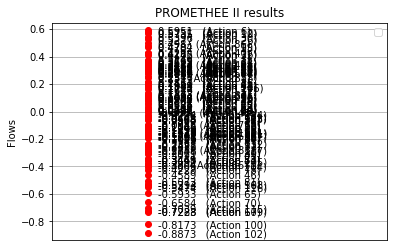

In [11]:
bubu = main('y', 'y')

In [12]:
setores['phi'] = gpd.GeoSeries(bubu)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  """Entry point for launching an IPython kernel.


In [13]:
setores

,ID,CD_GEOCODI,AREA_KM2,Rank,NDVI,Dens_Dem_H,Renda,Infra,%Alfabetiz,geometry,phi
0,88939.0,352670405000001,0.16547,9,-0.81,0.64,0.76,0.57,0.98,"POLYGON ((-47.38783 -22.18287, -47.38729 -22.1...",0.3769
1,88940.0,352670405000002,0.23188,22,-0.78,0.74,0.97,-0.18,0.95,"POLYGON ((-47.38756 -22.18164, -47.38668 -22.1...",0.2161
2,88941.0,352670405000003,0.18694,27,-0.26,0.34,0.81,0.57,0.12,"POLYGON ((-47.38244 -22.18438, -47.38201 -22.1...",0.2546
3,88942.0,352670405000004,0.11315,25,-0.38,0.12,0.59,0.57,0.57,"POLYGON ((-47.38602 -22.18627, -47.38573 -22.1...",0.3470
4,88943.0,352670405000005,0.07081,40,-0.64,-0.29,0.90,-0.18,0.78,"POLYGON ((-47.38846 -22.19355, -47.38716 -22.1...",0.2860
...,...,...,...,...,...,...,...,...,...,...,...
112,89065.0,352670405000127,0.04004,80,-0.41,-0.90,-0.66,0.57,-0.33,"POLYGON ((-47.36536 -22.19351, -47.36393 -22.1...",-0.0498
113,89066.0,352670405000128,0.05945,71,0.97,-0.50,-0.64,0.57,-0.84,"POLYGON ((-47.35998 -22.19504, -47.35840 -22.1...",-0.0224
114,89067.0,352670405000129,1.18708,104,0.28,0.76,-0.83,-0.97,-0.91,"POLYGON ((-47.35091 -22.18240, -47.34884 -22.1...",-0.7039
115,89068.0,352670405000130,0.33769,103,0.29,0.03,-0.98,-0.97,-0.55,"POLYGON ((-47.35874 -22.18511, -47.35848 -22.1...",-0.5474


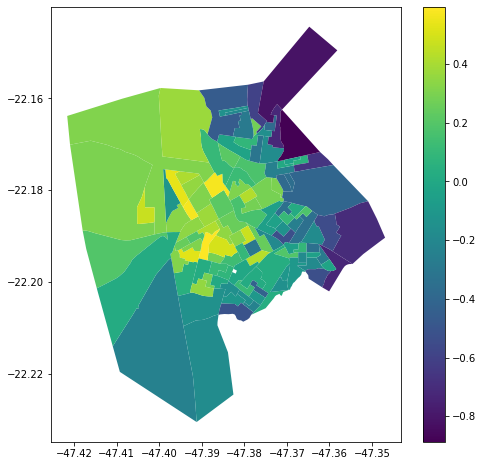

In [14]:
setores.plot(cmap = 'viridis', column ='phi', figsize = (8,8), legend=True) # colorido por Renda

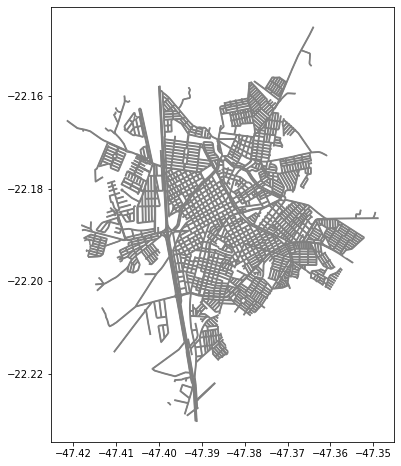

In [15]:
logradouros = gpd.read_file('Logradouros.shp')
logradouros.drop([7778], inplace=True)
logradouros.plot(color='grey', figsize = (8,8))

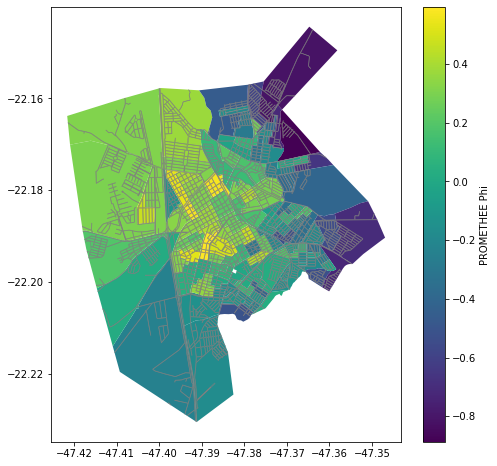

In [17]:
f, ax = plt.subplots(figsize = (8,8))
setores.plot(ax=ax, cmap = 'viridis', column ='phi', legend=True, legend_kwds={'label': "PROMETHEE Phi"}) # Phi
logradouros.plot(ax=ax, color='grey', linewidth=0.5)
plt.show()

In [18]:
setores['phi'].min()

-0.8873

In [19]:
setores['phi'].max()

0.5951